In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'Biased Sampling'))

In [2]:
import pandas as pd

from TabNet import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer
from stealthy_sampling import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
data = pd.read_csv('../../../Dataset/PhiUSIIL_Phishing_URL_Dataset.csv')
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
protected_feature='IsHTTPS'
data = data.dropna(axis=0)
data.head()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,100.0,1.000000,0.522907,0.061933,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,100.0,0.666667,0.032650,0.050207,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,100.0,0.866667,0.028555,0.064129,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,100.0,1.000000,0.522907,0.057606,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,100.0,1.000000,0.079963,0.059441,3,1,0,...,1,0,1,244,15,34,72,1,85,1


In [4]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='label',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling only continuous numerical features (excluding heuristic categoricals and protected feature by default).
Features actually being scaled: ['URLLength', 'DomainLength', 'TLDLegitimateProb', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfCSS', 'NoOfEmptyRef']


In [5]:
print(len(x_train.columns))
x_train.head()

19


,URLLength,DomainLength,IsDomainIP,TLDLegitimateProb,HasObfuscation,IsHTTPS,LineOfCode,LargestLineLength,Robots,NoOfURLRedirect,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasPasswordField,Bank,Pay,Crypto,NoOfCSS,NoOfEmptyRef
98258,-0.134650,0.059642,0,-0.922760,0,1,-0.185396,-0.077576,0,0,-0.053741,0.067997,0,0,0,0,0,-0.015936,0.032389
131577,-0.231504,-0.379189,0,-0.922760,0,1,0.422297,-0.074531,0,0,-0.053741,-0.095874,0,0,0,0,0,-0.060824,0.350060
201592,-0.183077,-0.159773,0,1.041476,0,1,0.180121,-0.075475,1,0,-0.053741,-0.259745,0,0,0,0,0,-0.049602,0.032389
159643,-0.134650,0.059642,0,-1.028299,0,1,1.472474,-0.056584,0,0,-0.053741,3.345417,0,1,1,1,0,-0.049602,0.138279
170726,-0.328358,-0.818020,0,-0.964647,0,1,-0.184108,-0.016243,1,0,-0.053741,0.067997,0,0,1,0,1,0.230949,-0.020556


Accuracy: 0.9982046678635548
Precision: 0.9982046747106196
Recall: 0.9982046678635548
F-1: 0.9982045977840341


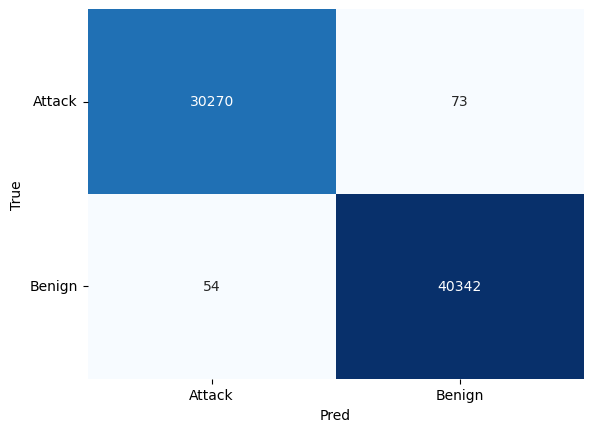

In [6]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [7]:
# Pass the DataFrame to the attacker class to maintain feature names for plotting
attacker = AdversarialSHAPBackgroundAttack(
        model=model,
        X_train=x_train,
        sensitive_feature_name=protected_feature,
        sensitive_feature_index=list(x_train.columns).index(protected_feature),
        explainer_type='deep',
        background_size=200,
        lambda_reg=1e-4,
        gamma_entropy=1e-7
    )

Running attack with DeepExplainer...


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


[Before] Mean SHAP per feature:
[-1.73549471  0.15438852  0.         -0.01102508  0.          1.03643004
  0.50288991  0.12822582 -0.00491294  0.0444977   0.00979746  0.35118508
 -0.00901266 -0.05199234 -0.12104626 -0.03114897 -0.01288566  0.2114414
  0.4680802 ]


Converting A to a CSC (compressed sparse column) matrix; may take a while.
Converting P to a CSC (compressed sparse column) matrix; may take a while.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Weight stats: min=0.0028451702586873495, max=0.00834011592987707, mean=0.005000000000005262
[After] Mean SHAP per feature:
[-3.63532570e-01 -4.03318264e-01  0.00000000e+00 -2.87012716e-02
  0.00000000e+00  1.20675230e+00  1.66651778e+00 -1.17895169e+00
 -6.47913274e-03  1.94050326e-02  1.08263872e-01  6.04637432e-01
 -2.97902897e-04 -9.76015953e-02 -1.71327844e-01 -1.09004108e-01
 -5.20620840e-03 -3.86035688e-02  5.55912096e-01]


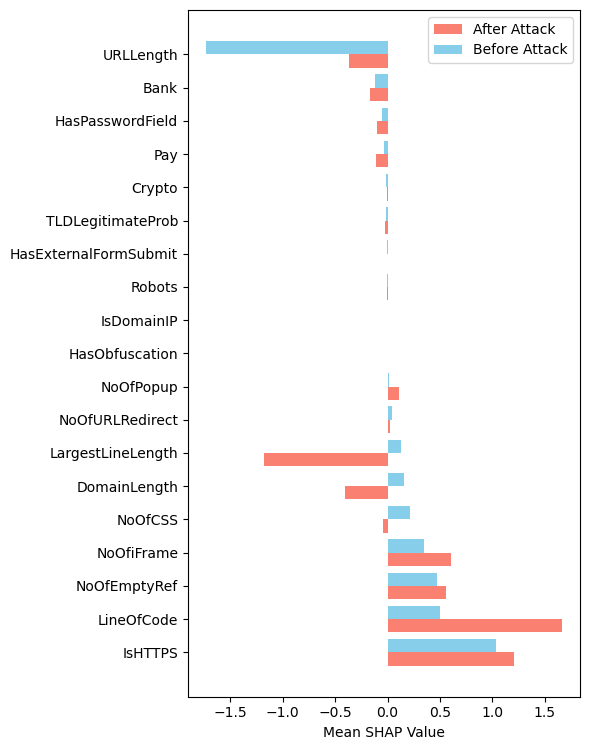

In [8]:
biased_weights, before, after = attacker.run_attack()
attacker.plot_shap_comparison(before, after)

In [9]:
print(f"Sensitive feature '{protected_feature}' importance before attack: {before[attacker.sensitive_feature_index]:.4f}")
print(f"Sensitive feature '{protected_feature}' importance after attack: {after[attacker.sensitive_feature_index]:.4f}")
    
change = after[attacker.sensitive_feature_index] - before[attacker.sensitive_feature_index]
pct_change = (change / before[attacker.sensitive_feature_index] * 100) if before[attacker.sensitive_feature_index] != 0 else float('inf')
print(f"Change in importance: {change:.4f} ({pct_change:.2f}%)")

Sensitive feature 'IsHTTPS' importance before attack: 1.0364
Sensitive feature 'IsHTTPS' importance after attack: 1.2068
Change in importance: 0.1703 (16.43%)
